In [3]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

In [4]:
def get_data():
    x_train_ = pd.read_csv('X_train.csv').drop('id', axis=1)
    y_train_ = pd.read_csv('y_train.csv', usecols=['y'])
    x_test_ = pd.read_csv('X_test.csv').drop('id', axis=1)
    return x_train_, y_train_, x_test_

In [14]:
x_train, y_train, x_test = get_data()

array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

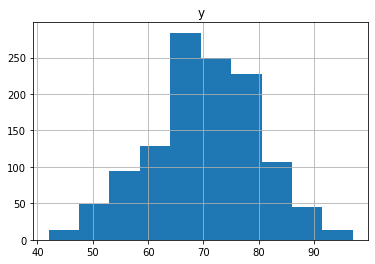

In [15]:
y_train.hist()